In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util
import json
from PIL import Image
import io
import numpy as np
import zipfile

### QUICK GUIDE
Add tensorflow-great-barrier-reef folder to the data folder. Then run the code.  
kaggle competitions download -c tensorflow-great-barrier-reef 

In [2]:
# Some params
class_id = 1
class_name = "cots"
has_annotation = True
split_ratio = 0.9

In [3]:
# Create work space
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_dir = os.path.join(base_dir, "data")

if not os.path.exists(os.path.join(data_dir, "tf_record_data")):
    os.mkdir(os.path.join(data_dir, "tf_record_data"))

train_dir = os.path.join(data_dir, "tf_record_data")
create_dirs = ["annotations", "images", "training_data"]
for dir in create_dirs:
    exists = os.path.exists(os.path.join(train_dir, dir))
    if not exists:
        os.mkdir(os.path.join(train_dir, dir))

In [4]:
# Move images to /tf_record_data/images
image_dir = os.path.join(
    data_dir, "tensorflow-great-barrier-reef", "train_images"
)
videos = [
    v
    for v in os.listdir(
        os.path.join(data_dir, "tensorflow-great-barrier-reef", "train_images")
    )
    if v != ".DS_Store"
]
image_paths = [
    os.path.join(image_dir, video, image)
    for video in videos
    for image in os.listdir(os.path.join(image_dir, video))
]

dest = os.path.join(data_dir, "tf_record_data", "images", "train")
for image_path in image_paths:
    sourc = image_path

    video_frame = os.path.basename(image_path)
    video_id = sourc.split(os.sep)[-2].split("_")[-1]
    image_id = f"{video_id}-{video_frame}"

    dest = os.path.join(data_dir, "tf_record_data", "images", image_id)
    shutil.move(str(sourc), str(dest))

In [5]:
# Load train.csv
meta_path = os.path.join(data_dir, "tensorflow-great-barrier-reef", "train.csv")
train_meta_df = pd.read_csv(meta_path)
train_meta_df.iloc[16:20, :]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]"
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]"
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]"
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]"


In [6]:
# Coco format COCO Bounding box: (x-top left, y-top left, width, height)
# Pascal format Pascal VOC Bounding box :(x-top left, y-top left,x-bottom right, y-bottom right)
# Image pixel counts start top left corner ?


# Fix annotation
def fix_anno(anno):
    # Was on text format, need to change it to list with dict
    # Also json.loads expects " not '
    return json.loads(anno.replace("'", '"'))


def to_pascal(row):
    coco_list = row["annotations_coco"]
    pascal_list = []
    for coco in coco_list:
        x_left = coco["x"]
        y_top = coco["y"]
        x_right = coco["x"] + coco["width"]
        y_bottom = coco["y"] + coco["height"]
        pascal_dict = {
            "x_left": x_left,
            "y_top": y_top,
            "x_right": x_right,
            "y_bottom": y_bottom,
        }
        pascal_list.append(pascal_dict)
    return pascal_list


def box_id(row, class_id):
    anno = row["annotations_pascal"]
    N = len(anno)
    if N == 0:
        return []
    id_list = [class_id for i in range(N)]
    return id_list


def box_class_names(row, class_name):
    anno = row["annotations_pascal"]
    N = len(anno)
    if N == 0:
        return []
    class_name_list = [class_name for i in range(N)]
    return class_name_list


train_meta_df["annotations_coco"] = train_meta_df.apply(
    lambda row: fix_anno(row["annotations"]), axis=1
)
train_meta_df["annotations_pascal"] = train_meta_df.apply(
    lambda row: to_pascal(row), axis=1
)
train_meta_df["class_ids"] = train_meta_df.apply(
    lambda row: box_id(row, class_id), axis=1
)
train_meta_df["class_names"] = train_meta_df.apply(
    lambda row: box_class_names(row, class_name), axis=1
)

pd.set_option("display.max_colwidth", None)

train_meta_df.iloc[16:20]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,annotations_coco,annotations_pascal,class_ids,class_names
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 559, 'y_top': 213, 'x_right': 609, 'y_bottom': 245}]",[1],[cots]
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 558, 'y_top': 213, 'x_right': 608, 'y_bottom': 245}]",[1],[cots]
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]","[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]","[{'x_left': 557, 'y_top': 213, 'x_right': 607, 'y_bottom': 245}]",[1],[cots]
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]","[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]","[{'x_left': 556, 'y_top': 214, 'x_right': 606, 'y_bottom': 246}]",[1],[cots]


In [7]:
# Create label_map for training of model

label_map = f"""item {{
    id:{class_id}
    name:"{class_name}"
}} """


if not os.path.isfile(
    os.path.join(data_dir, "tf_record_data", "training_data", "label_map.txt")
):
    with open(
        os.path.join(
            data_dir, "tf_record_data", "training_data", "label_map.txt"
        ),
        "w",
    ) as f:
        f.write(label_map)

In [9]:
# TODO Write test
def split_train_val(train_meta_df, ratio=split_ratio):
    train_df = train_meta_df.sample(frac=split_ratio)
    val_df = train_meta_df.drop(train_df.index)
    return train_df, val_df


# ref: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
# ref: https://www.kaggle.com/code/khanhlvg/cots-detection-w-tensorflow-object-detection-api
# ref: https://github.com/datitran/raccoon_dataset
# has_annotation -> True/False if we only want to use training data which has annotation
def create_tf_example(row, data_path=data_dir):
    # Define names for row variables
    image_id = row["image_id"]
    annotations = row["annotations_pascal"]
    class_ids = row["class_ids"]
    class_names = [
        class_name.encode("utf-8") for class_name in row["class_names"]
    ]

    # Specify path to image file
    file_format = "jpg"
    file_path = os.path.join(
        data_path, "tf_record_data", "images", image_id + "." + file_format
    )

    # Get image file
    with tf.io.gfile.GFile(file_path, "rb") as f:
        encoded_img = f.read()

    encoded_img_bytes_io = io.BytesIO(encoded_img)
    image = Image.open(encoded_img_bytes_io)

    # Ready bbox for tf_example
    x_left = []
    y_top = []
    x_right = []
    y_bottom = []
    # bbox values need to be normalized (not quite sure why, but everybody does it)
    for anno in annotations:
        x_left.append(anno["x_left"] / image.size[0])  # Divide by width
        y_top.append(anno["y_top"] / image.size[1])  # Divide by heigth
        x_right.append(anno["x_right"] / image.size[0])  # Divide by width
        y_bottom.append(anno["y_bottom"] / image.size[1])  # Divide by height

    tf_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image/height": dataset_util.int64_feature(image.size[1]),
                "image/width": dataset_util.int64_feature(image.size[0]),
                "image/filename": dataset_util.bytes_feature(
                    image_id.encode("utf-8")
                ),
                "image/source_id": dataset_util.bytes_feature(
                    image_id.encode("utf-8")
                ),
                "image/encoded": dataset_util.bytes_feature(encoded_img),
                "image/format": dataset_util.bytes_feature(
                    file_format.encode("utf-8")
                ),
                "image/object/bbox/x_left": dataset_util.float_list_feature(
                    x_left
                ),
                "image/object/bbox/y_top": dataset_util.float_list_feature(
                    y_top
                ),
                "image/object/bbox/x_right": dataset_util.float_list_feature(
                    x_right
                ),
                "image/object/bbox/y_bottom": dataset_util.float_list_feature(
                    y_bottom
                ),
                "image/object/class/text": dataset_util.bytes_list_feature(
                    class_names
                ),
                "image/object/class/label": dataset_util.int64_list_feature(
                    class_ids
                ),
            }
        )
    )
    return tf_example


if has_annotation == True:
    # Filters out only the frames which has bbox
    train_meta_df = train_meta_df.loc[
        train_meta_df["annotations_pascal"].map(len) > 0
    ]

# Split on ratio and get train and validation sets.
train_df, val_df = split_train_val(train_meta_df)

# Gathe Examples in TF Record
output_path_train = os.path.join(
    data_dir, "tf_record_data", "training_data", "train.tfrecord"
)
# train.tfrecord
writer = tf.io.TFRecordWriter(output_path_train)
for index, row in train_df.iterrows():
    tf_exampele = create_tf_example(row)
    writer.write(tf_exampele.SerializeToString())
# validation.tfrecord
output_path_validation = os.path.join(
    data_dir, "tf_record_data", "training_data", "validation.tfrecord"
)

writer = tf.io.TFRecordWriter(output_path_validation)
for index, row in val_df.iterrows():
    tf_exampele = create_tf_example(row)
    writer.write(tf_exampele.SerializeToString())

2022-04-24 01:14:50.639138: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


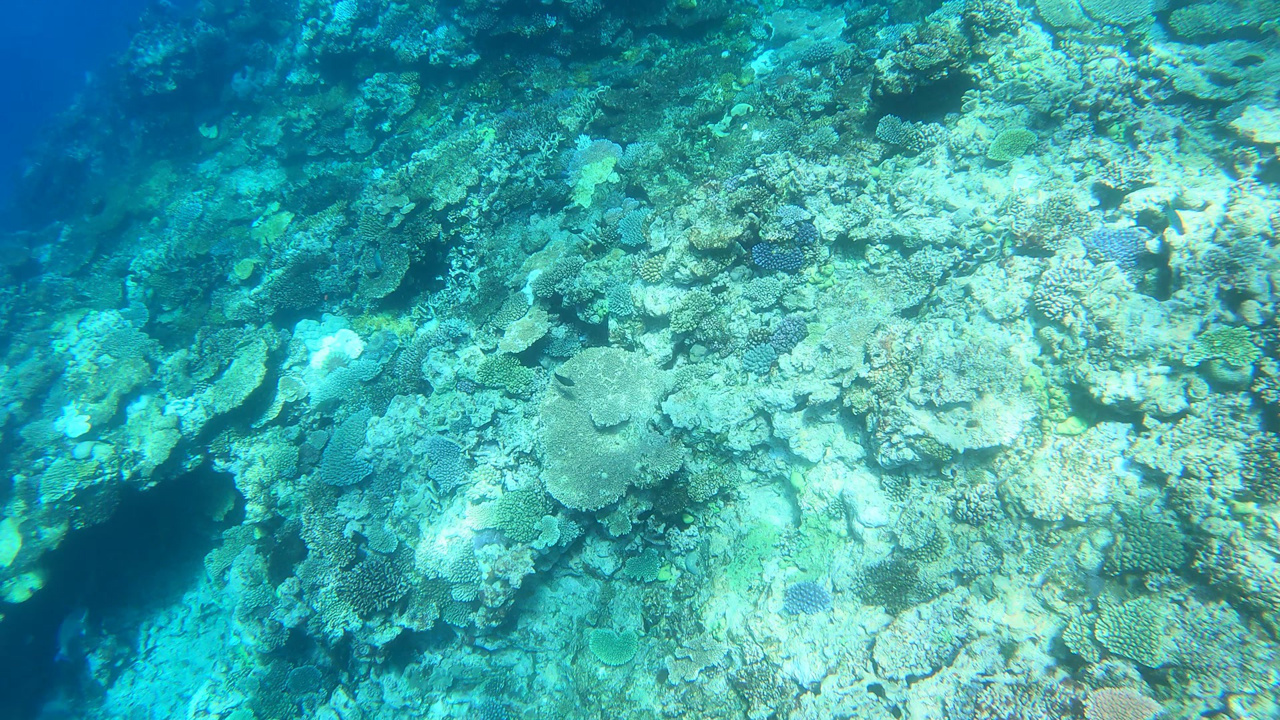

In [10]:
# Validation to see if tfrecord worked

result = {}
filenames = "/Users/olaaflo/cots_detection/data/tf_record_data/training_data/train.tfrecord"
raw_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for key, feature in example.features.feature.items():

        kind = feature.WhichOneof("kind")
        result[key] = np.array(getattr(feature, kind).value)


encoded_img_bytes_io = io.BytesIO(result["image/encoded"])
image = Image.open(encoded_img_bytes_io)
image  # Looks fine !